**ADA Project** \
**Group: WorkingTeam2023** \
Autumn semester 2023 

Milestone P2: from point 0 to point 5\
Milestone P3: from point 6 onwards

In [48]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import ast
import requests
from scipy import stats
import seaborn as sns
import datetime
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from empath import Empath
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess
import networkx as nx
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Loading the data

In [2]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [3]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

# 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [4]:
# Print the size of plot and meta_data dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's first check if 'Wikipedia movie ID' can be used as a unique key to merge the two dataframes :

In [5]:
# Find out how many duplicates there are in the datasets
print("Numbers of duplicated Wikipedia movie ID in the metadata dataframe : ", movie_metadata["Wikipedia movie ID"].duplicated().sum())
print("Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe : ", plot_summaries["Wikipedia movie ID"].duplicated().sum())

Numbers of duplicated Wikipedia movie ID in the metadata dataframe :  0
Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe :  0


We can see that there are no duplicates in the Wikipedia movie ID column, so we can use it as a unique key to merge the two dataframes. Let's do it; We merge the two dataframes 'left' on the Wikipedia movie ID column, so that we keep all the movies in the metadata dataframe, even those that doesn't have a plot description.

In [6]:
# Merge 'left' the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID column
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [7]:
# Check the number and percentage of null values in each column of all_movies as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

print(all_movies.shape)
all_movies_null


(81741, 10)


,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? It's very unlikely that 2 movies have the exact same entry, but let's check that :

In [8]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate! In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. To try to catch the real duplicates, we'll search for rows that share all the same columns except the IDs columns.

In [9]:
# Check for duplicates on all columns except for the ID columns
check_duplicates = all_movies[all_movies.duplicated(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], keep=False)]

check_duplicates.sort_values(by=["Movie name"])

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
35927,33545359,/m/0hgm4mx,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
77623,33545325,/m/0hgpm4_,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
640,32505827,/m/0h1cbks,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
75111,32517667,/m/0h1dthj,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
7009,9386528,/m/0286tgz,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
79631,9386447,/m/0286tdx,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
9911,20695929,/m/051zsk3,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
22389,20696066,/m/051zc20,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
6010,31255600,/m/0gjb35n,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN
53387,31255791,/m/0gjf1sq,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN


We notice that those films have a lot of NaN values, but since they share all the same values we don't have a valid reason not to drop them. That's why we chose to drop one of each pair.

In [10]:
# drop one of each pair of duplicates
all_movies.drop_duplicates(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], inplace=True, keep="first")

## Data cleaning

### Movie release date


Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :

In [11]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
338894,2988222,/m/08h_w9,2001-04-20,Utah / Elmo,1957-09-29,M,1.80,NaN,Andrew Dice Clay,43.0,/m/03lctd7,/m/0cf1tw_,/m/027x63
237823,11948988,/m/02rz91y,NaN,NaN,1923-06-08,M,NaN,NaN,Myron Healey,NaN,/m/04dbwxk,NaN,/m/03c53l7
362401,8626367,/m/027bjzg,1938-11-03,NaN,1884-08-07,F,1.60,NaN,Billie Burke,NaN,/m/02vb7zk,NaN,/m/02gdtw
171301,9104215,/m/027xrrq,1964,Sandhya,1941-09-02,F,NaN,NaN,Sadhana,22.0,/m/0hppz3s,/m/0hppz3w,/m/0cfwz4
271527,9959871,/m/02py4c8,2003,NaN,1940-04-25,M,1.70,/m/0xnvg,Al Pacino,62.0,/m/0cc0krw,NaN,/m/0bj9k
386610,25542269,/m/09rsmds,2010-05-21,Senator Garver,1959-10-08,M,NaN,NaN,Kevin Skousen,50.0,/m/0b_t7jl,/m/0b_t7jp,/m/0bcvvvr
242652,23432334,/m/06w7r1x,1944-09-22,Mrs. Nelson,1909-02-09,F,1.57,NaN,Heather Angel,35.0,/m/0n22d0r,/m/0n22d0v,/m/07z7g5
251259,29019907,/m/0dgnpdf,1997-10-23,NaN,1969-11-28,M,NaN,NaN,Stuart Laing,27.0,/m/0ggn0wc,NaN,/m/0c_bmz
95450,4104202,/m/0bj75b,2005-12-02,NaN,NaN,M,NaN,NaN,Nick Perata,NaN,/m/0jy7q2,NaN,/m/0jy7nx
246941,11453506,/m/02rd7zm,1914-10-29,NaN,1889-04-16,M,1.65,/m/06j2v,Charlie Chaplin,NaN,/m/03kzgx1,NaN,/m/01lc5


Converting the movie release date to keep only the year for the all_movie table :

In [12]:
all_movies = keep_the_year(all_movies, key='Movie release date')

### Dictionnary structures

In [13]:
# Print examples of the 'Movie countries', 'Movie genres' and 'Movie languages' columns as well as their types
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{"/m/09c7w0": "United States of America"}
<class 'str'>
{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
<class 'str'>
{"/m/02h40lc": "English Language"}
<class 'str'>


We see that some columns are written as a dictionnary but saved as a string. 

Three columns are concerned by this problem:
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

Since we will not use the Freebase IDs, let's only keep the values of these dicts as lists.

In [14]:
all_movies['Movie genres'] = [list(eval(genre).values()) for genre in all_movies['Movie genres']]
all_movies['Movie languages'] = [list(eval(genre).values()) for genre in all_movies['Movie languages']]
all_movies['Movie countries'] = [list(eval(genre).values()) for genre in all_movies['Movie countries']]
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

['United States of America']
<class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western']
<class 'list'>
['English Language']
<class 'list'>


Now, we have a proper dataframe containing metadata and plot summaries about movies: all_movies

# 2. Preprocessing characters metadata

In [15]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
267135,5649438,/m/0dy5gj,1997-01-24,NaN,1986-02-22,M,1.6000,NaN,Miko Hughes,10.0,/m/0k8byf,NaN,/m/05wpyn
279267,1595142,/m/05f7xf,2002-02-15,NaN,1967-02-20,F,NaN,NaN,Kath Soucie,34.0,/m/0k2hmk,NaN,/m/024my5
174642,20377220,/m/04z_cyz,1991-09-15,Carlos,1963-12-16,M,1.8800,/m/09vc4s,Benjamin Bratt,27.0,/m/052htyj,/m/0h2qbgj,/m/01tfck
149280,896395,/m/03mr85,1957-12-13,Norman Page,1934-12-30,M,1.7500,NaN,Russ Tamblyn,22.0,/m/05kk2sm,/m/05kk2sq,/m/039fwd
76697,431530,/m/027r7k,1979-02-01,Sherlock Holmes,1929-12-13,M,1.7780,/m/044038p,Christopher Plummer,49.0,/m/02vc5ym,/m/06rkl,/m/01ycbq
3255,142274,/m/011xrr,1984-08-15,Dr. Emilio Lizardo,1945-10-19,M,1.9300,/m/07bch9,John Lithgow,38.0,/m/0h2t1s_,/m/0h2t1t2,/m/01yk13
286941,5334800,/m/0dg3yq,2006-12-15,Levi,1969-05-29,M,NaN,NaN,Dominic Comperatore,37.0,/m/0c10ggq,/m/0c10ggt,/m/0c10gh0
439107,13396960,/m/03c3z9s,1979,NaN,1914-06-25,M,NaN,NaN,Paul Julian,64.0,/m/07snrd8,NaN,/m/09xh_f
198352,9522233,/m/02phq4r,2007-11-08,NaN,1954-10-03,M,1.8796,NaN,Sathyaraj,53.0,/m/03lz7_b,NaN,/m/05kfc1
238227,11439529,/m/02rcnxv,2001-03-01,Rens,1972-01-24,M,1.8700,NaN,Daan Schuurmans,29.0,/m/0dls0vs,/m/0jg6tcj,/m/03c0ttd


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and " Actor date of birth" as seen before. Let's convert every entry to only a year when it's possible :

In [16]:
character_metadata = keep_the_year(character_metadata, key='Movie release date')
character_metadata = keep_the_year(character_metadata, key='Actor date of birth')

# 3. Learning more about the data

### Chronological evolution of movie production

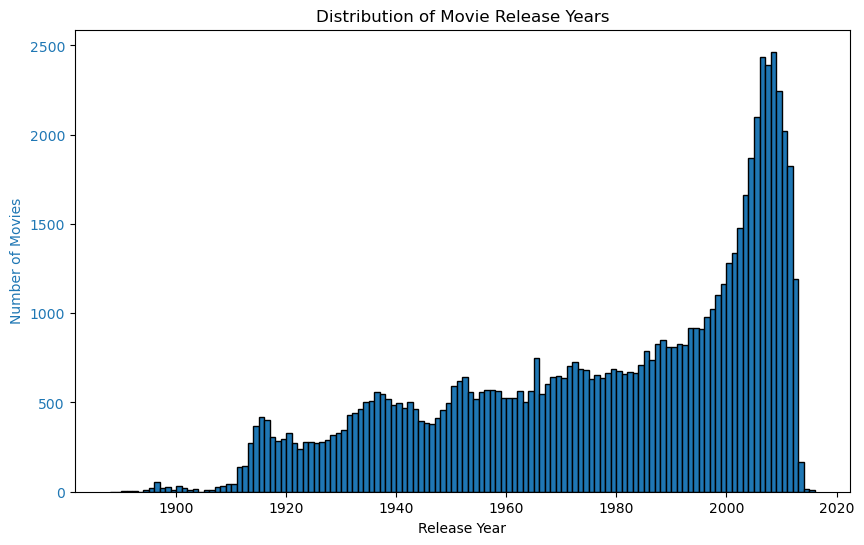

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Distribution of Movie Release Years')
plt.show()

Looking at the plot we can see that we have more data for recent films.

### Movie countries and genres

We compute the top 10 countries and genres. For co-produced movies, we count an additional movie per co-producing country. For example, a movie co-produced by the USA and India will add +1 movie produced for both of these countries. The same logic applies for the movie genres.

In [18]:
# Print number of unique movie countries, genres and languages

unique_countries_list = all_movies['Movie countries'].explode().unique()
unique_genres_list = all_movies['Movie genres'].explode().unique()
unique_languages_list = all_movies['Movie languages'].explode().unique()

print('Number of unique movie countries:', len(unique_countries_list))
print('Number of unique movie genres:', len(unique_genres_list))
print('Number of unique movie languages:', len(unique_languages_list))

Number of unique movie countries: 148
Number of unique movie genres: 364
Number of unique movie languages: 208


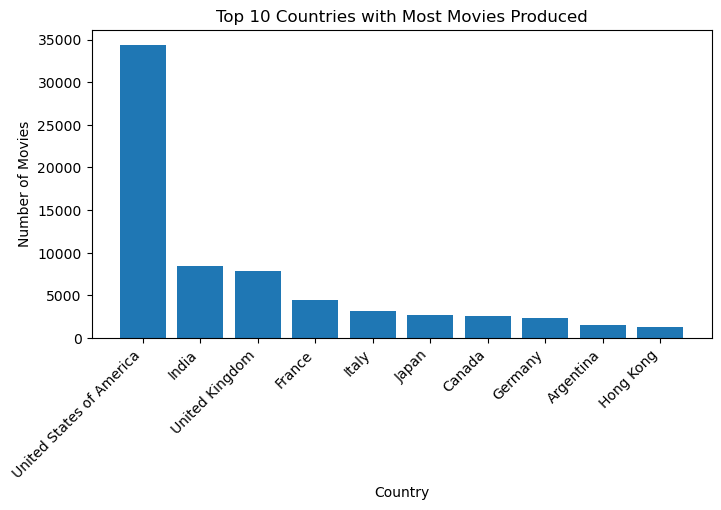

The top production country is United States of America and concerns 39.81% of all movies produced.


In [19]:
# Compute a box plot of top 10 countries with most movies produced or coproduced
country_counts = {}

for countries in all_movies['Movie countries']:
    for country in countries:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

# Get the top 10 countries
top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top countries
top_countries_df = pd.DataFrame(top_countries, columns=['Country', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_countries_df['Country'], top_countries_df['Count'])
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Top 10 Countries with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 country and its percentage
top_1_country = top_countries_df['Country'].iloc[0]
percentage = country_counts[top_1_country] / sum(country_counts.values()) * 100
print(f'The top production country is {top_1_country} and concerns {percentage:.2f}% of all movies produced.')

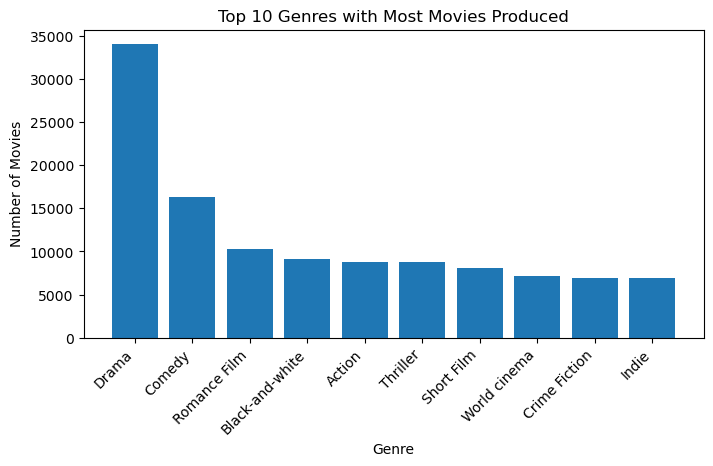

The top genre is Drama and represents 13.98% of all movies produced.


In [20]:
# Compute a box plot of top 10 genres with most movies produced
genre_counts = {}

for genres in all_movies['Movie genres']:
    for genre in genres:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get the top 10 genres
top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_genres_df['Genre'], top_genres_df['Count'])
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Genres with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_genre = top_genres_df['Genre'].iloc[0]
percentage = genre_counts[top_1_genre] / sum(genre_counts.values()) * 100
print(f'The top genre is {top_1_genre} and represents {percentage:.2f}% of all movies produced.')

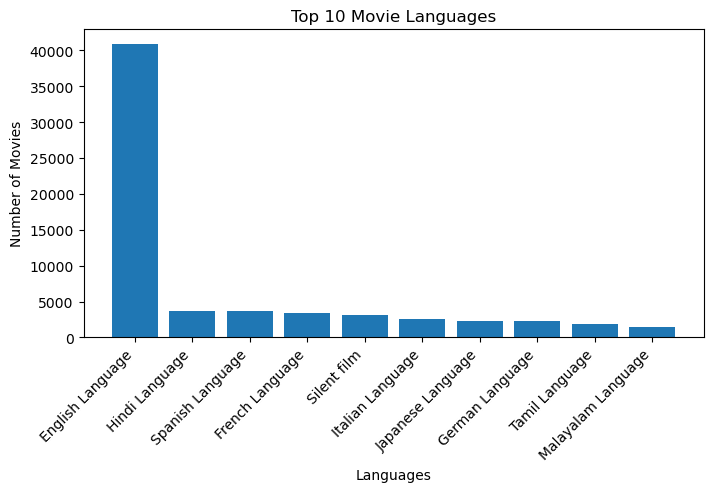

The top language is "English Language" and represents 50.29% of all movies produced.


In [21]:
# Compute a box plot of top 10 genres with most movies produced
language_counts = {}

for languages in all_movies['Movie languages']:
    for language in languages:
        if language in language_counts:
            language_counts[language] += 1
        else:
            language_counts[language] = 1

# Get the top 10 genres
top_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_languages_df = pd.DataFrame(top_languages, columns=['Language', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_languages_df['Language'], top_languages_df['Count'])
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.title('Top 10 Movie Languages')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_language = top_languages_df['Language'].iloc[0]
percentage = language_counts[top_1_language] / sum(language_counts.values()) * 100
print(f'The top language is "{top_1_language}" and represents {percentage:.2f}% of all movies produced.')


These results show us that an analysis of the whole dataset will actually be more representative of movies produced or co-produced in the USA, movies belonging to the genre Drama and movies in english. The reason why the percentage of english movies is so high is not only because the USA is the largest producing country but also because a lot of movies might be translated in english.

## Missing values

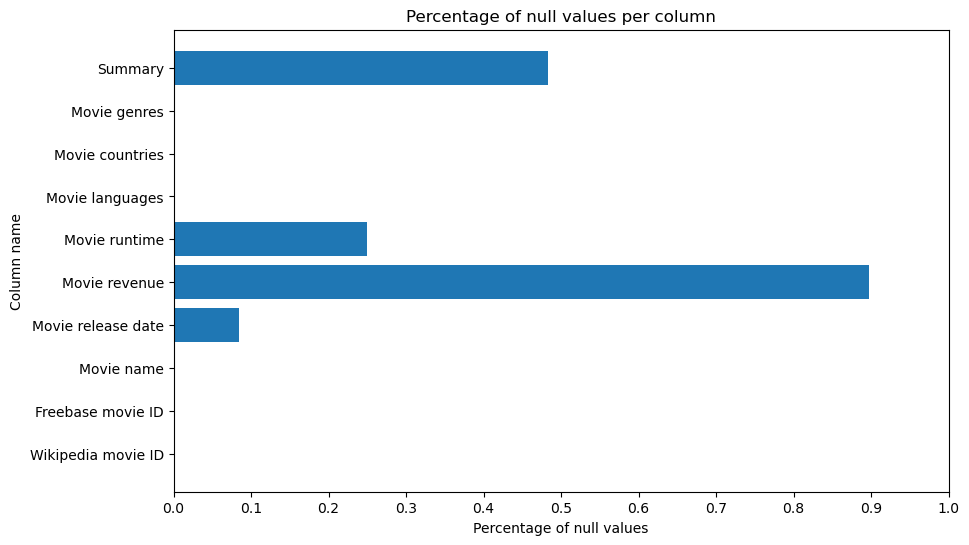

Percentage of missing values in movie revenue: 89.72%


In [22]:
# plot the percentage of missing values for all columns in the all_movies dataframe
plt.figure(figsize=(10, 6))
plt.barh(all_movies_null.index, all_movies_null['Percentage of null values'])
plt.xlabel('Percentage of null values')
plt.ylabel('Column name')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.title('Percentage of null values per column')
plt.show()

print(f"Percentage of missing values in movie revenue: {100*all_movies_null['Percentage of null values']['Movie revenue']:.2f}%")

We see that there are a lot of missing values of the movie revenues (around 90%), we need to find another metric for judging films popularity. IMDb ratings seem to be a good alternative. This dataset contains the average IMDb rating of movies and the number of votes.

# 4. Add IMDb ratings

### Load the data

In [23]:
movie_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', header=0)

In [24]:
movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


### Use Wikidata query to create a table that links IMDb identifier tconst with Freebase ID

Since multiple movies have the same name and appear the same year, we have to link the two dataset using freebase ID of the movies in the original dataset and the unique identifier tconst of the IMDb ratings dataset. We use Wikidata query to create a link table

In [25]:
# Create the table
link_id = link_tconst_freebaseID()

# Drop duplicates
link_id = link_id.drop_duplicates(subset=['tconst'])
link_id = link_id.drop_duplicates(subset=['Freebase movie ID'])

link_id.head()

,tconst,Freebase movie ID
0,tt0074486,/m/027jhb
1,nm4823140,/m/02f7lv
2,tt0056801,/m/01v74p
3,nm4331485,/m/06zn0tq
4,tt0172871,NaN


### Merge the two datasets

In [26]:
# Add freebase ID to movie_ratings
movie_ratings = pd.merge(movie_ratings, link_id, on='tconst', how='left')
movie_ratings.head()

,tconst,averageRating,numVotes,Freebase movie ID
0,tt0000001,5.7,2006,/m/0kvdsy
1,tt0000002,5.8,269,/m/02pz844
2,tt0000003,6.5,1909,/m/0g53g2
3,tt0000004,5.5,178,/m/02pzdsc
4,tt0000005,6.2,2689,/m/0jq3g


In [27]:
# Merge all_movies and movie_ratings
all_movies = pd.merge(all_movies, movie_ratings, on='Freebase movie ID', how='left')
# Drop tconst column
all_movies.drop(columns=['tconst'], inplace=True)

all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",4.9,56908.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,6.0,69.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",5.9,623.0


In [28]:
# Percentage of missing values in the columns averageRatings and num votes
print('Percentage of missing values in averageRatings: {:.2f}%'.format(100 * all_movies['averageRating'].isnull().sum() / len(all_movies)))
print('Percentage of missing values in numVotes: {:.2f}%'.format(100 * all_movies['numVotes'].isnull().sum() / len(all_movies)))

Percentage of missing values in averageRatings: 16.99%
Percentage of missing values in numVotes: 16.99%


We have far fewer missing values in ratings than in revenues.

### Correlation between movie revenue and average rating

Percentage of movies for which we have both informations: 10.18% 
 

Person correlation between movie revenue and average rating:  PearsonRResult(statistic=0.16827121878890383, pvalue=6.415827841218535e-54) 
 



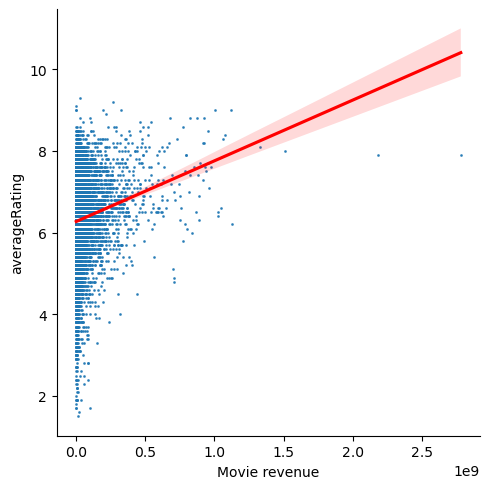

In [29]:
# Keep movies for which we have both informations
df1 = all_movies.dropna(subset=['Movie revenue', 'averageRating'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df1) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df1_pearson = stats.pearsonr(df1['Movie revenue'], df1['averageRating'])
print("Person correlation between movie revenue and average rating: ", df1_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='averageRating', data=df1, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its average rating.

### Correlation between movie revenue and number of votes for rating

Percentage of movies for which we have both informations: 10.18% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=0.6549975631261252, pvalue=0.0) 
 



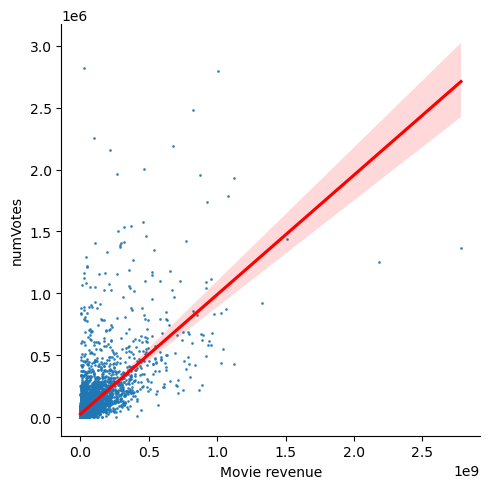

In [30]:
# Keep movies for which we have both informations
df2 = all_movies.dropna(subset=['Movie revenue', 'numVotes'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df2) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df2_pearson = stats.pearsonr(df2['Movie revenue'], df2['numVotes'])
print("Person correlation between movie revenue and numVotes: ",df2_pearson, '\n', '\n')


# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='numVotes', data=df2, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its number of votes.

Looking at the previous graphs, the positive correlation between the data confirms that using the movie reviews and number of votes in a similar extent as the movie revenue is reasonable.

# 5. Correlation

Exploring possible correlatinos in our dataset.

### Movie release year - Movie average rating

/var/folders/_x/0l8g7_k500xbjv2lxq_rdbvc0000gn/T/ipykernel_25812/148172858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Movie release date'] = df3['Movie release date'].astype(int)



 
 Percentage of movies for which we have both informations: 77.55% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=-0.055269258864619586, pvalue=4.461857817778891e-44) 
 



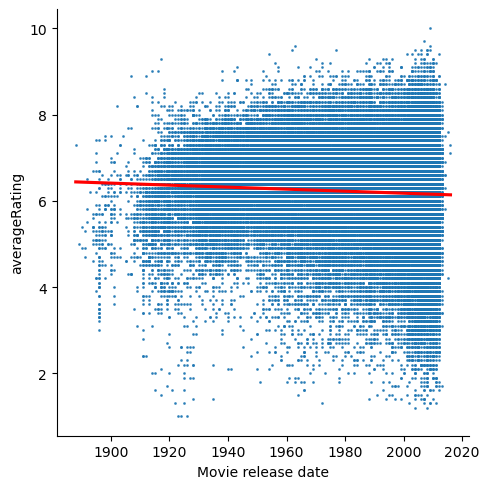

In [31]:
# Keep movies for which we have both informations
df3 = all_movies.dropna(subset=['Movie release date', 'averageRating'])
df3['Movie release date'] = df3['Movie release date'].astype(int)

# What percentage of the whole dataset does it represent
print('\n', '\n', "Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df3) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df3_pearson = stats.pearsonr(df3['Movie release date'], df3['averageRating'])
print("Person correlation between movie revenue and numVotes: ", df3_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie release date', y='averageRating', data=df3, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significative but very weak negative correlation between the two variables.

# 6. NLP Topic detection

In order to point out the main themes in the movie plot summaries, we perform an NLP topic detection analysis. 

## Data cleaning

To perform NLP with a better performance, a few transformation and modification are needed on the summaries. \
We did the following transformations:
- Tokenization on white space
- Removal of punctuation
- Casefolding
- Stopword removal: based on the "english" stopword library from nltk
- Removal of common words in summaries: some words are very common in movie plot summaries (film, films, movie and movies) and don't bring a lot of additional informaiton, we decide to remove them
- Removal of common names: we realized that a lot of topic were described with first names. In our case, it doesn't bring any relevant information. We decide to remove a list of names taken from an internet source (https://data.world/davidam/international-names/workspace/data-dictionary )
- Lemmatization

These steps are made in the get_summaries() function available in the helpers file. This function creates the processes_summaries.tsv file which can be later used without re-running the function.\
The other steps of data cleaning detailed in milestone P2 are made through the get_cleaned_data() function for the sake of simplification.

In [49]:
path = '../data/'
all_movies_cleaned, character_metadata_cleaned, name_clusters_cleaned = get_cleaned_data(path)

# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary'])
all_movies_cleaned.head()


Loading the data...
Loading and cleaning the summaries...
processed_summaries.tsv not found, processing the summaries...
Tokenizing...
Removing punctuation...
Casefolding...
Removing stop words and common words/names...
Removing common words...
Removing common names...
Lemmatizing...
Saving the processed summaries...
Cleaning the data...
Adding IMDb ratings...


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",half century depicts planet terraformed allowi...,4.9,56908.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",series murder woman throughout distinctive sig...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],upper housewife becomes frustrated leaf arroga...,5.9,623.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",hundred year evil return claim fingall talisma...,NaN,NaN
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",work cab side hard committing girlfriend want ...,5.8,1129.0


## Topic detection

### Topic detection on the whole dataset

To start our analysis, we perform the topic detection on the whole cleaned dataset.

We see that setting the number of topics to 8 seems to give us the best results. Indeed, less topics give us results that are more vague and more than 8 topics results in overlapping topics.

In [50]:
# Tokenize the text in the 'Summary' column
all_movies_cleaned['Summary_tokens'] = all_movies_cleaned['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

By setting the lambda at 0.5, we see that the main topic genre can be interpreted as:
- Topic 1: Drama and/or Relationships
- Topic 2: Horror
- Topic 3: Detective and/or Crime
- Topic 4: War
- Topic 5: Musical
- Topic 6: Western
- Topic 7: Supernatural
- Topic 8: Undefined, related to animals or creatures

We observe that the term 'war' is part of the top 30 most salient terms. Furthermore, one of the major societal fear, war, is very represented in our movies as it has a topic on its own.

### Topic detection on war movies

Since 'war' seems to be one of the societal fear that is the more represented in our dataset. Let's dive in a more precise analysis of this topic. To do this, we first need to select all the movies talking about war. We select movies that belong to a genre containing the word 'war' in it. \

Since war is already a topic of its own, we perform the topic detection on a smaller number of topic, 4.

In [ ]:
# Print all possible genres that contain the word "war"
print("All possible genres that contain the word 'war':", all_movies_cleaned['Movie genres'].apply(lambda x: [item for item in x if 'war' in item.lower()]).explode().unique())

# Select movies for which no genre in the list 'Movie genre' contain the word "war"
all_movies_genre_war = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

# Tokenize the text in the 'Summary' column
all_movies_genre_war['Summary_tokens'] = all_movies_genre_war['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_genre_war['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_genre_war['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

All possible genres that contain the word 'war': [nan 'War film' 'Gulf War' 'Anti-war' 'Anti-war film' 'Nuclear warfare'
 'Cold War' 'War effort' 'The Netherlands in World War II']


/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_96274/1180759538.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_genre_war['Summary_tokens'] = all_movies_genre_war['Summary'].apply(simple_preprocess)


### Topic detection on non-war movies

Movies about war seem to be very present in our dataset. Therefore, it is possible that this over-representation of this theme hides other themes about other societal fears. To take a closer look to other themes, let's remove the movies about war. \

Once again, since we are looking into a smaller dataset, we choose to perform the topic detection on 4 topics.

In [ ]:
# Select movies for which no genre in the list 'Movie genre' contain the word "war"
all_movies_genre_not_war = all_movies_cleaned[~all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

# Tokenize the text in the 'Summary' column
all_movies_genre_not_war['Summary_tokens'] = all_movies_genre_not_war['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_genre_not_war['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_genre_not_war['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_96274/2726125112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_genre_not_war['Summary_tokens'] = all_movies_genre_not_war['Summary'].apply(simple_preprocess)


KeyboardInterrupt: 

We can intepret the four topics title as:
- Topic 1: Drama and/or Relationships and/or Family
- Topic 2: Action
- Topic 3: Science-fiction and/or War
- Topic 4: Love and/or Bollywood movies

By looking at the words appearing in topic 3, we see that some societal fears could be represented the movies close to this topics.

### Smooth topic detection over time

In [ ]:
import tqdm

def weighted_bow(data, dictionary):
    # Aggregate the yearly bow into a dataframe with columns year, word_id, weight
    # where for each word_id, the weight is weighted sum of the distribution of the word in the yearly bow, centered around the year
    
    # Create a bow for each year  
    yearly_bow = []
    for year in data['Movie release date'].unique():
        year_agg = data[data['Movie release date'] == year]['Summary_tokens'].sum()
        bow = dictionary.doc2bow(year_agg)
        # make truples of (year, word_id, count)
        bow = [(word_id, year, count) for word_id, count in bow]
        yearly_bow.append(bow)

    # make a dataframe with the yearly bow
    yearly_bow = pd.DataFrame([item for sublist in yearly_bow for item in sublist], columns=['word_id', 'year', 'count'])
    
    # create a distribution lookup table for all the differences between two years
    years = data['Movie release date'].unique()
    distrib_weights = {}
    for diff in range(max(years) - min(years) + 1):
        distrib_weights[diff] = np.exp(-(diff)**2 / 1000)

    # aggregate the yearly bow into a dataframe with columns year, word_id, weight
    weights_df = pd.DataFrame(columns=['year', 'word_id', 'weight'])
    for year in tqdm.tqdm(years):
        # aggregate the yearly bow. Group by word_id and sum the counts using the weights from the distribution lookup table
        # custom aggregation function
        def weighted_sum(x):
            return np.sum(x['count'] * abs(x['year'] - year).map(distrib_weights))
        
        yearly_bow_agg = yearly_bow.groupby('word_id').apply(weighted_sum).reset_index()
        yearly_bow_agg.columns = ['word_id', 'weight']
        yearly_bow_agg['year'] = year
        weights_df = pd.concat([weights_df, yearly_bow_agg], axis=0)


    return weights_df

In [ ]:
#copy of all_movies_cleaned where we drop the rows with missing values in the 'Movie release date' column
all_movies_cleaned_copy = all_movies_cleaned.dropna(subset=['Movie release date'])

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned_copy['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned_copy['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

#weights = weighted_bow(all_movies_cleaned_copy, dictionary) #takes quite long to run
weights = pd.read_csv('../data/bow_weights.csv')

weights_copy = weights.copy()

# Normalize the weights
weights_copy['weight'] = weights_copy['weight'] / weights_copy.groupby('year')['weight'].transform('sum')

In [ ]:
# get the weights for each word_id for the year YEAR
YEAR = 2001 # can be changed
weights_year = weights_copy[weights_copy['year'] == YEAR].sort_values(by='word_id')['weight'].tolist()

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], eta=weights_year, random_state=params['random_state'])

In [ ]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

# 7. Lexicons

For this project we want to know how are societal fears depicted in movies. What are the main global societal fears?\
[The Chapman University](https://www.chapman.edu/wilkinson/research-centers/babbie-center/survey-american-fears.aspx) conducts yearly studies based on surveys in the United States of America, giving us a starting point for an answer. By taking a look at the results of the surveys from 2018 to 2023, we have chosen to consider 7 majors global fears, which are the following :
- War
- Climate Change
- Terrorism
- Pandemics
- Economical Collapse
- Technological Advancement
- Aliens

In order to select movies that are the closest to each societal fear we are interested to analyze, we create a lexicon for each of these fears.

In [107]:
lexicon = Empath()

# Create categories in the lexicon 

# Define terms related to war 
war_terms = ["war", "conflict", "battle", "combat", "military",  "soldier", "army", "weapons", "violence", "warfare", "casualties", "peacekeeping"]
# Create a category for "war" in the lexicon 
lexicon.create_category("war", war_terms)

# Define terms related to climate change
climate_change_terms = [ "global_warming", "greenhouse_gas", "carbon_footprint", "renewable_energy", "climate_action", "temperature_rise", "sea_level_rise", " environmental_impact", "pollution"]
# Create a category for "climate change" in the lexicon
lexicon.create_category("climate change", climate_change_terms)

# Define terms related to terrorism
terrorism_terms = ["terrorism", "extremism", "radicalization", "terrorist_attack", "security_threat", "counterterrorism", "homeland_security"]
# Create a category for "terrorism" in the lexicon
lexicon.create_category("terrorism", terrorism_terms)

# Define terms related to pandemics
pandemic_terms = ["pandemic", "epidemic", "outbreak", "virus", "infection", "quarantine", "isolation", "vaccination", "public_health", "contagion"] 
# Create a category for "pandemic" in the lexicon
lexicon.create_category("pandemic", pandemic_terms)

# Define terms related to economic collapse
economic_collapse_terms = ["economic_crisis", "financial_collapse", "recession", "depression", "bankruptcy", "unemployment", "market_crash", "financial_downturn", "economic_downturn"]
# Create terms related to "economic collapse" in the lexicon
lexicon.create_category("economic collapse", economic_collapse_terms)

# Define terms related to technology advancement 
technology_terms = ["robotics", "artificial_intelligence", "automation", "machine_learning", "data_science", "computer_vision", "nanotechnology", "virtual_reality", "augmented_reality", "smart_technology", "innovation", "emerging_technologies"]
# Create terms related to "robot/AI/technology" in the lexicon
lexicon.create_category("technology", technology_terms)

# Define terms related to aliens and extraterrestrial life 
alien_terms = ["extraterrestrial", "alien", "UFO", "alien_abduction", "extraterrestrial_life", "space_invaders", "E.T.", "unidentified_flying_object", "close_encounter", "Martian", "interstellar", "alien_technology"]
# Create terms related to "alien" in the lexicon
lexicon.create_category("alien", alien_terms) 


["battle", "war", "army", "armies", "rebels", "Objects", "legions", "forces", "legion", "raids", "Empire", "fighters", "battlefield", "battles", "invaders", "rebellion", "Romans", "allies", "Germans", "assassins", "military", "tribes", "leadership", "ranks", "front_lines", "Titans", "opposition", "troops", "mercenaries", "weaponry", "soldiers", "mages", "wars", "warriors", "Knights", "camps", "colony", "magicians", "Lycans", "bloodshed", "enemy", "enemies", "Object", "Alliance", "generals", "organization", "Marines", "front_line", "platoon", "knights", "Hunters", "warfare", "empire", "brethren", "Brotherhood", "terrorists", "mercenary", "Army", "raiders", "comrades", "tribe", "Elders", "nation", "Council", "casualties", "Empire", "killing", "Greeks", "commander", "region", "commanders", "giants", "Carpathians", "assassination", "marines", "Nazis", "Rogues", "clans", "civilians", "Elves", "raid", "mutants", "revolution", "pirates", "nations", "fleet", "government", "slaughter", "Nubians

In [109]:
fear_categories = ['war','climate change', 'terrorism', 'pandemic', 'economic collapse', 'technology', 'alien']

# New column in the dataframe that contains the frequency of word in the plot belonging to each fear category
all_movies_lexicon = all_movies_cleaned.copy()
all_movies_lexicon['lexicon'] = all_movies_lexicon['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon['{}'.format(category)] = all_movies_lexicon['lexicon'].apply(lambda x: x['{}'.format(category)])

all_movies_lexicon = all_movies_lexicon.drop('lexicon', axis=1)

### General analysis of frequency values

Percentage of movies for which we don't have the release date: 4.97%


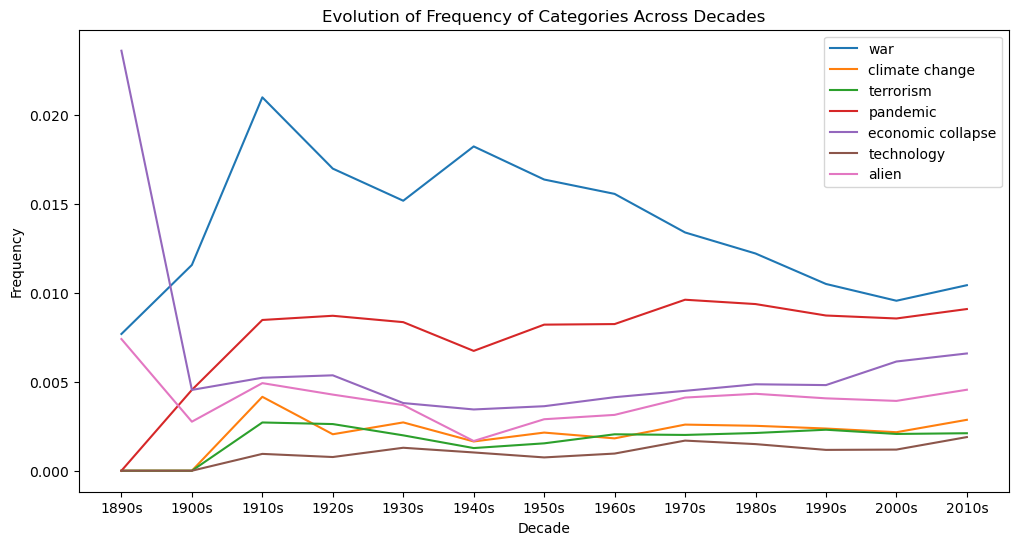

In [137]:
# Filter movies with score > 0 for at least one fear category
filtered_movies = all_movies_lexicon[all_movies_lexicon[fear_categories].apply(lambda x: x > 0).any(axis=1)]

# Print percentage of movies for which we don't have the release date
print("Percentage of movies for which we don't have the release date: {:.2f}%".format(100 * filtered_movies['Movie release date'].isnull().sum() / len(filtered_movies)))
# Drop movies for which we don't have the release date
filtered_movies = filtered_movies.dropna(subset=['Movie release date'])

# Group the movies by decade and calculate the mean frequency for each category
filtered_movies['Movie release date'] = filtered_movies['Movie release date'].astype(int)
filtered_movies['Decade'] = filtered_movies['Movie release date'].apply(lambda x: x- (x % 10))
category_freq_by_decade_mean = filtered_movies.groupby('Decade')[fear_categories].mean() # Du sens de faire la mean ici alors qu'il 

# Plot the evolution of frequency for each category
plt.figure(figsize=(12, 6))
for category in fear_categories:
    plt.plot(category_freq_by_decade_mean.index, category_freq_by_decade_mean[category], label=category)


plt.xlabel('Decade')
# x tick labels with 1890s, 1900s, etc.
plt.xticks(category_freq_by_decade_mean.index, ['{}s'.format(decade) for decade in category_freq_by_decade_mean.index])
plt.ylabel('Frequency')
plt.title('Evolution of Frequency of Categories Across Decades')
plt.legend()
plt.show()


# Sentiment analysis

We analyze the different sentiments that are present in movies depicting societal fears.

In [54]:
analyzer = SentimentIntensityAnalyzer()

In [112]:
all_movies_lexicon.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes,Summary_tokens,war,climate change,terrorism,pandemic,economic collapse,technology,alien
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",half century depicts planet terraformed allowi...,4.9,56908.0,"[half, century, depicts, planet, terraformed, ...",0.019737,0.006579,0.0,0.019737,0.000000,0.0,0.006579
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",series murder woman throughout distinctive sig...,6.1,2895.0,"[series, murder, woman, throughout, distinctiv...",0.020513,0.005128,0.0,0.020513,0.005128,0.0,0.000000
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],upper housewife becomes frustrated leaf arroga...,5.9,623.0,"[upper, housewife, becomes, frustrated, leaf, ...",0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",hundred year evil return claim fingall talisma...,NaN,NaN,"[hundred, year, evil, return, claim, fingall, ...",0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",work cab side hard committing girlfriend want ...,5.8,1129.0,"[work, cab, side, hard, committing, girlfriend...",0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [113]:
# Compute polarity scores for each movie summary
all_movies_lexicon['sentiment'] = all_movies_lexicon['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Link fears

We analyze the links between the different fear categories

In [114]:
all_movies_lexicon.head()
all_movies_lexicon_graph = all_movies_lexicon.copy()

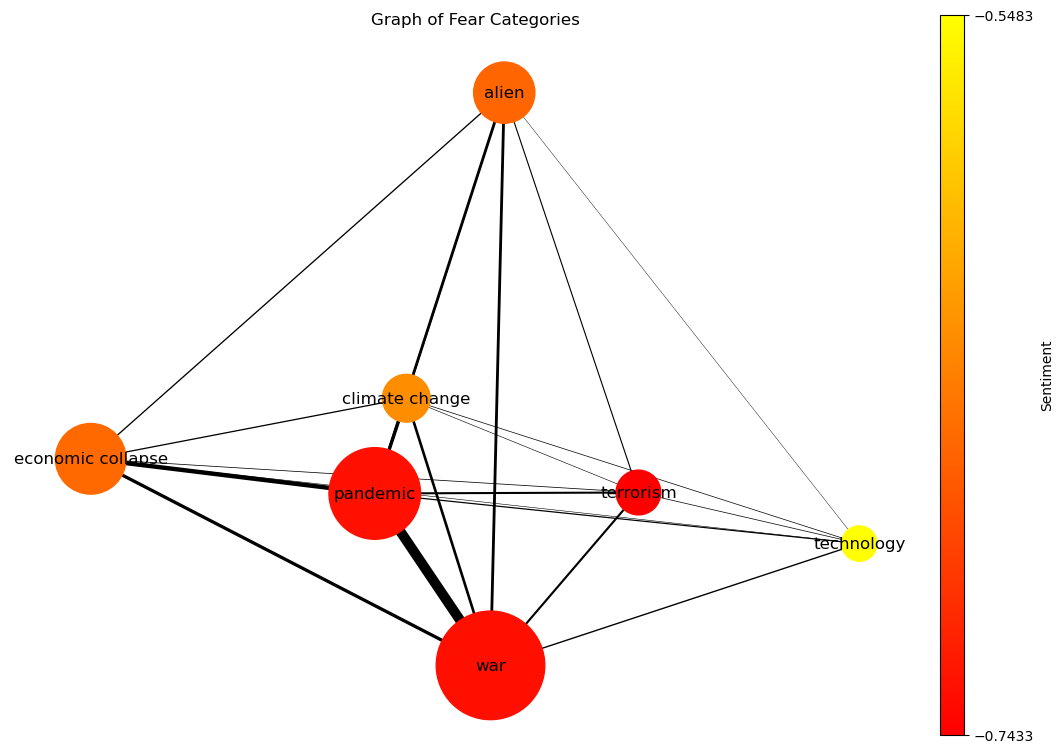

In [124]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Create a link graph
G = nx.Graph()
seed = 2

#TODO: Normalization according to the length of a lexicon

# Compute the mean frequency of each category
category_freq = all_movies_lexicon_graph[fear_categories].mean()

# Add a node for each fear category, the size of the node is proportional to the mean frequency of the category
for fear in fear_categories:
    G.add_node(fear, size=category_freq[fear])

# Create a dataframe that contain all the combinations of categories and a column for a score according to the number of movies that have both categories
# TODO: Maybe change the way the score is computed: add weight to take into account the frequency of the categories
link_table = pd.DataFrame(columns=['category1', 'category2', 'common_movies', 'common_words'])
for i in range(len(fear_categories)):
    for j in range(i+1, len(fear_categories)):
        category1 = fear_categories[i]
        category2 = fear_categories[j]
        common_movies= 0
        common_words = 0
        row_to_add = [category1, category2, common_movies, common_words]
        link_table.loc[len(link_table.index)] = row_to_add

# For each movie, if the movie has both categories, add 1 to the score of the link between the two categories
for index, row in all_movies_lexicon_graph.iterrows():
    for i in range(len(fear_categories)):
        for j in range(i+1, len(fear_categories)):
            category1 = fear_categories[i]
            category2 = fear_categories[j]
            if row[category1] != 0 and row[category2] != 0:
                link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_movies'] += 1

# Compute the number of common words between two categores
for index, row in link_table.iterrows():
    category1 = row['category1']
    category2 = row['category2']
    set_a = set(lexicon.cats[category1])
    set_b = set(lexicon.cats[category2])
    link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_words'] = len(set_a & set_b)


# Create a dataframe with all categories and their the mean sentiment score of each category
sentiment_table = pd.DataFrame(columns=['category', 'sentiment'])
for category in fear_categories:
    category_sentiment = all_movies_lexicon_graph[all_movies_lexicon_graph[category] != 0]['sentiment'].mean()
    row_to_add = [category, category_sentiment]
    sentiment_table.loc[len(sentiment_table.index)] = row_to_add

# Change the color of the node according to the sentiment score of the category
min_sentiment = sentiment_table['sentiment'].min()
max_sentiment = sentiment_table['sentiment'].max()

for index, row in sentiment_table.iterrows():
    sentiment = row['sentiment']

    # Use a colormap to map the sentiment to a color
    color = cm.autumn((sentiment - min_sentiment) / (max_sentiment - min_sentiment))

    G.nodes[row['category']]['color'] = color


# Add an edge between two categories if they have at least one common word, and weight the edge with the number of common words
for index, row in link_table.iterrows():
    if row['common_words'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_words'])
pos = nx.spring_layout(G, seed=seed) # Position nodes using Fruchterman-Reingold force-directed algorithm, based on edges corresponding to the common words

# Remove all edges
G.remove_edges_from(list(G.edges()))

# Add an edge between two categories if the score is greater than 0, and weight the edge with the common_movies score, those edge will be displayed
for index, row in link_table.iterrows():
    if row['common_movies'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_movies'])

# Draw the graph with a colorbar
plt.figure(figsize=(12, 9))
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[node]['size']*1000000 for node in G.nodes()], node_color=node_colors)
edges = nx.draw_networkx_edges(G, pos, width=[G.edges[edge]['weight']/1000 for edge in G.edges()])
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.title('Graph of Fear Categories')

# Create a colorbar based on sentiment values
norm = Normalize(vmin=min_sentiment, vmax=max_sentiment)
sm = plt.cm.ScalarMappable(cmap=cm.autumn, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Create an axis for the colorbar
cax = plt.axes([0.9, 0.1, 0.02, 0.8])  # Adjust the position as needed
cbar = plt.colorbar(sm, cax=cax, ticks=[min_sentiment, max_sentiment])  # Specify tick locations

cbar.set_label('Sentiment')

plt.show()

The above graph should be interpreted the following way:
- The size of the nodes is proportional to the mean frequency of the category
- The distance between the nodes is proportional to the similarity between the lexicals
- The size of the links connecting the nodes is proportional to the number of movies that have non-zero values in both lexicons
- The color of the node represents the mean sentiment for this category

We can derive several conclusions from the observation of the graph:
- The lexicons of war and pandemic are the most similar lexicons, both in their lexicons definition and in the movies they contain
- All fear lexicons have a negative mean sentiment

/var/folders/_x/0l8g7_k500xbjv2lxq_rdbvc0000gn/T/ipykernel_25812/3764083570.py:35: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.31578947]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



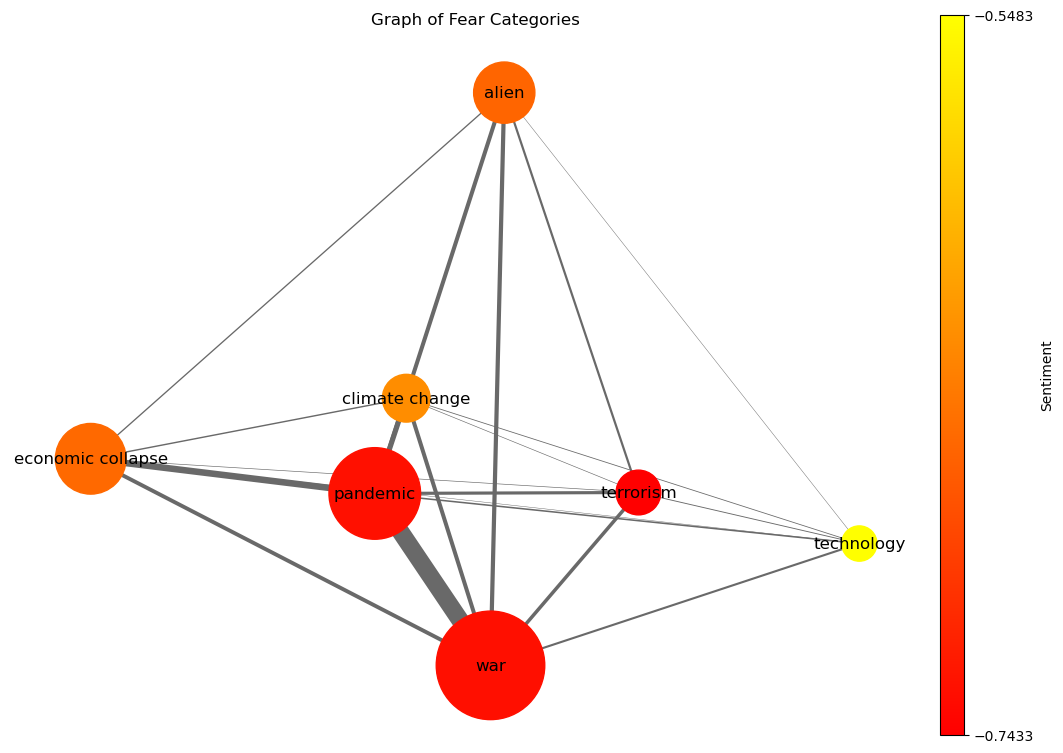

In [134]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Create a link graph
G = nx.Graph()
seed = 2

#TODO: Normalization according to the length of a lexicon

# Compute the mean frequency of each category
category_freq = all_movies_lexicon_graph[fear_categories].mean()

# Add a node for each fear category, the size of the node is proportional to the mean frequency of the category
for fear in fear_categories:
    G.add_node(fear, size=category_freq[fear])

# Create a dataframe that contain all the combinations of categories and a column for a score according to the number of movies that have both categories
link_table = pd.DataFrame(columns=['category1', 'category2', 'common_movies', 'common_words'])
for i in range(len(fear_categories)):
    for j in range(i+1, len(fear_categories)):
        category1 = fear_categories[i]
        category2 = fear_categories[j]
        common_movies= 0
        common_words = 0
        row_to_add = [category1, category2, common_movies, common_words]
        link_table.loc[len(link_table.index)] = row_to_add

# For each movie, if the movie has both categories, add 1 to the score of the link between the two categories
for index, row in all_movies_lexicon_graph.iterrows():
    for i in range(len(fear_categories)):
        for j in range(i+1, len(fear_categories)):
            category1 = fear_categories[i]
            category2 = fear_categories[j]
            if row[category1] != 0 and row[category2] != 0:
                link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_movies'] += 50*(row[category1] + row[category2])


# Compute the number of common words between two categores
for index, row in link_table.iterrows():
    category1 = row['category1']
    category2 = row['category2']
    set_a = set(lexicon.cats[category1])
    set_b = set(lexicon.cats[category2])
    link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_words'] = len(set_a & set_b)


# Create a dataframe with all categories and their the mean sentiment score of each category
sentiment_table = pd.DataFrame(columns=['category', 'sentiment'])
for category in fear_categories:
    category_sentiment = all_movies_lexicon_graph[all_movies_lexicon_graph[category] != 0]['sentiment'].mean()
    row_to_add = [category, category_sentiment]
    sentiment_table.loc[len(sentiment_table.index)] = row_to_add

# Change the color of the node according to the sentiment score of the category
min_sentiment = sentiment_table['sentiment'].min()
max_sentiment = sentiment_table['sentiment'].max()

for index, row in sentiment_table.iterrows():
    sentiment = row['sentiment']

    # Use a colormap to map the sentiment to a color
    color = cm.autumn((sentiment - min_sentiment) / (max_sentiment - min_sentiment))

    G.nodes[row['category']]['color'] = color


# Add an edge between two categories if they have at least one common word, and weight the edge with the number of common words
for index, row in link_table.iterrows():
    if row['common_words'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_words'])
pos = nx.spring_layout(G, seed=seed) # Position nodes using Fruchterman-Reingold force-directed algorithm, based on edges corresponding to the common words

# Remove all edges
G.remove_edges_from(list(G.edges()))

# Add an edge between two categories if the score is greater than 0, and weight the edge with the common_movies score, those edge will be displayed
for index, row in link_table.iterrows():
    if row['common_movies'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_movies'])

# Draw the graph with a colorbar
plt.figure(figsize=(12, 9))
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[node]['size']*1000000 for node in G.nodes()], node_color=node_colors)
edges = nx.draw_networkx_edges(G, pos, width=[G.edges[edge]['weight']/1000 for edge in G.edges()], edge_color='dimgray')
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.title('Graph of Fear Categories')

# Create a colorbar based on sentiment values
norm = Normalize(vmin=min_sentiment, vmax=max_sentiment)
sm = plt.cm.ScalarMappable(cmap=cm.autumn, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Create an axis for the colorbar
cax = plt.axes([0.9, 0.1, 0.02, 0.8])  # Adjust the position as needed
cbar = plt.colorbar(sm, cax=cax, ticks=[min_sentiment, max_sentiment])  # Specify tick locations

cbar.set_label('Sentiment')

plt.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

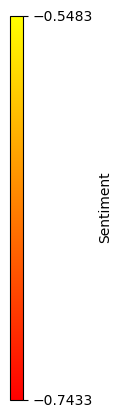

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Create a link graph
G = nx.Graph()
seed = 2

#TODO: Normalization according to the length of a lexicon

# Compute the mean frequency of each category
category_freq = all_movies_lexicon_graph[fear_categories].mean()

# Add a node for each fear category, the size of the node is proportional to the mean frequency of the category
for fear in fear_categories:
    G.add_node(fear, size=category_freq[fear])

# Create a dataframe that contain all the combinations of categories and a column for a score according to the number of movies that have both categories
# TODO: Maybe change the way the score is computed: add weight to take into account the frequency of the categories
link_table = pd.DataFrame(columns=['category1', 'category2', 'common_movies', 'common_words'])
for i in range(len(fear_categories)):
    for j in range(i+1, len(fear_categories)):
        category1 = fear_categories[i]
        category2 = fear_categories[j]
        common_movies= 0
        common_words = 0
        row_to_add = [category1, category2, common_movies, common_words]
        link_table.loc[len(link_table.index)] = row_to_add

# For each movie, if the movie has both categories, add 1 to the score of the link between the two categories
for index, row in all_movies_lexicon_graph.iterrows():
    for i in range(len(fear_categories)):
        for j in range(i+1, len(fear_categories)):
            category1 = fear_categories[i]
            category2 = fear_categories[j]
            if row[category1] != 0 and row[category2] != 0:
                link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_movies'] += 1

# Compute the number of common words between two categores
for index, row in link_table.iterrows():
    category1 = row['category1']
    category2 = row['category2']
    set_a = set(lexicon.cats[category1])
    set_b = set(lexicon.cats[category2])
    link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_words'] = len(set_a & set_b)


# Create a dataframe with all categories and their the mean sentiment score of each category
sentiment_table = pd.DataFrame(columns=['category', 'sentiment'])
for category in fear_categories:
    category_sentiment = all_movies_lexicon_graph[all_movies_lexicon_graph[category] != 0]['sentiment'].mean()
    row_to_add = [category, category_sentiment]
    sentiment_table.loc[len(sentiment_table.index)] = row_to_add

# Change the color of the node according to the sentiment score of the category
min_sentiment = sentiment_table['sentiment'].min()
max_sentiment = sentiment_table['sentiment'].max()

for index, row in sentiment_table.iterrows():
    sentiment = row['sentiment']

    # Use a colormap to map the sentiment to a color
    color = cm.autumn((sentiment - min_sentiment) / (max_sentiment - min_sentiment))

    G.nodes[row['category']]['color'] = color


# Add an edge between two categories if they have at least one common word, and weight the edge with the number of common words
for index, row in link_table.iterrows():
    if row['common_words'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_words'])
pos = nx.spring_layout(G, seed=seed) # Position nodes using Fruchterman-Reingold force-directed algorithm, based on edges corresponding to the common words

# Remove all edges
G.remove_edges_from(list(G.edges()))

# Add an edge between two categories if the score is greater than 0, and weight the edge with the common_movies score, those edge will be displayed
for index, row in link_table.iterrows():
    if row['common_movies'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_movies'])

# create plotly network graph
        
fig = go.Figure(data = [go.Scatter(x = [], y = [], mode = 'lines', line = dict(width = 0.5, color = 'grey'), hoverinfo = 'none')]) # invisible edges for the layout 
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x = tuple([x0, x1, None]), y = tuple([y0, y1, None]), mode = 'lines', line = dict(width = G.edges[edge]['weight']/1000, color = 'grey'), hoverinfo = 'none'))

for node in G.nodes():
    x, y = pos[node]
    node_color = G.nodes[node]['color']
    node_size = G.nodes[node]['size']
    fig.add_trace(go.Scatter(x = tuple([x]), y = tuple([y]), mode = 'markers', marker = dict(size = node_size*1000000, color = node_color), hoverinfo = 'none'))

fig.update_layout(showlegend = False, title = 'Graph of Fear Categories', xaxis = dict(showgrid = False, zeroline = False, showticklabels = False), yaxis = dict(showgrid = False, zeroline = False, showticklabels = False))

# Create a colorbar based on sentiment values
norm = Normalize(vmin=min_sentiment, vmax=max_sentiment)
sm = plt.cm.ScalarMappable(cmap=cm.autumn, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Create an axis for the colorbar
cax = plt.axes([0.9, 0.1, 0.02, 0.8])  # Adjust the position as needed
cbar = plt.colorbar(sm, cax=cax, ticks=[min_sentiment, max_sentiment])  # Specify tick locations

cbar.set_label('Sentiment')


fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

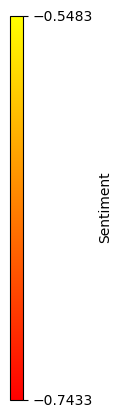

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Create a link graph
G = nx.Graph()
seed = 2

#TODO: Normalization according to the length of a lexicon

# Compute the mean frequency of each category
category_freq = all_movies_lexicon_graph[fear_categories].mean()

# Add a node for each fear category, the size of the node is proportional to the mean frequency of the category
for fear in fear_categories:
    G.add_node(fear, size=category_freq[fear])

# Create a dataframe that contain all the combinations of categories and a column for a score according to the number of movies that have both categories
# TODO: Maybe change the way the score is computed: add weight to take into account the frequency of the categories
link_table = pd.DataFrame(columns=['category1', 'category2', 'common_movies', 'common_words'])
for i in range(len(fear_categories)):
    for j in range(i+1, len(fear_categories)):
        category1 = fear_categories[i]
        category2 = fear_categories[j]
        common_movies= 0
        common_words = 0
        row_to_add = [category1, category2, common_movies, common_words]
        link_table.loc[len(link_table.index)] = row_to_add

# For each movie, if the movie has both categories, add 1 to the score of the link between the two categories
for index, row in all_movies_lexicon_graph.iterrows():
    for i in range(len(fear_categories)):
        for j in range(i+1, len(fear_categories)):
            category1 = fear_categories[i]
            category2 = fear_categories[j]
            if row[category1] != 0 and row[category2] != 0:
                link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_movies'] += 1

# Compute the number of common words between two categores
for index, row in link_table.iterrows():
    category1 = row['category1']
    category2 = row['category2']
    set_a = set(lexicon.cats[category1])
    set_b = set(lexicon.cats[category2])
    link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_words'] = len(set_a & set_b)


# Create a dataframe with all categories and their the mean sentiment score of each category
sentiment_table = pd.DataFrame(columns=['category', 'sentiment'])
for category in fear_categories:
    category_sentiment = all_movies_lexicon_graph[all_movies_lexicon_graph[category] != 0]['sentiment'].mean()
    row_to_add = [category, category_sentiment]
    sentiment_table.loc[len(sentiment_table.index)] = row_to_add

# Change the color of the node according to the sentiment score of the category
min_sentiment = sentiment_table['sentiment'].min()
max_sentiment = sentiment_table['sentiment'].max()

for index, row in sentiment_table.iterrows():
    sentiment = row['sentiment']

    # Use a colormap to map the sentiment to a color
    color = cm.autumn((sentiment - min_sentiment) / (max_sentiment - min_sentiment))

    G.nodes[row['category']]['color'] = color


# Add an edge between two categories if they have at least one common word, and weight the edge with the number of common words
for index, row in link_table.iterrows():
    if row['common_words'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_words'])
pos = nx.spring_layout(G, seed=seed) # Position nodes using Fruchterman-Reingold force-directed algorithm, based on edges corresponding to the common words

# Remove all edges
G.remove_edges_from(list(G.edges()))

# Add an edge between two categories if the score is greater than 0, and weight the edge with the common_movies score, those edge will be displayed
for index, row in link_table.iterrows():
    if row['common_movies'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_movies'])

# create plotly network graph
        
fig = go.Figure(data = [go.Scatter(x = [], y = [], mode = 'lines', line = dict(width = 0.5, color = 'grey'), hoverinfo = 'none')]) # invisible edges for the layout 
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x = tuple([x0, x1, None]), y = tuple([y0, y1, None]), mode = 'lines', line = dict(width = G.edges[edge]['weight']/1000, color = 'grey'), hoverinfo = 'none'))

for node in G.nodes():
    x, y = pos[node]
    node_color = G.nodes[node]['color']
    node_size = G.nodes[node]['size']
    fig.add_trace(go.Scatter(x = tuple([x]), y = tuple([y]), mode = 'markers', marker = dict(size = node_size*1000000, color = node_color), hoverinfo = 'none'))

fig.update_layout(showlegend = False, title = 'Graph of Fear Categories', xaxis = dict(showgrid = False, zeroline = False, showticklabels = False), yaxis = dict(showgrid = False, zeroline = False, showticklabels = False))

# Create a colorbar based on sentiment values
norm = Normalize(vmin=min_sentiment, vmax=max_sentiment)
sm = plt.cm.ScalarMappable(cmap=cm.autumn, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Create an axis for the colorbar
cax = plt.axes([0.9, 0.1, 0.02, 0.8])  # Adjust the position as needed
cbar = plt.colorbar(sm, cax=cax, ticks=[min_sentiment, max_sentiment])  # Specify tick locations

cbar.set_label('Sentiment')


fig.show()
